# Analysis of minimal pairs and homophones


In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import statsmodels.formula.api as sm
import seaborn as sns
from tqdm import tqdm

import src.utils as utils
import src.config as config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

## Pipeline

Here, we define the general pipeline to analyze pre-processed lexicons (real and artificial).

In [3]:
NUM_ARTIFICIAL = 10

In [4]:
def get_stats_for_lexicon(df_lex):
    """Return basic stats about lexicon. Number of homophones, etc."""
    return {'homophone_percentage': round((len(df_lex[df_lex['num_homophones']>0]) / len(df_lex)), 4),
            'mean_homophones': round(df_lex['num_homophones'].mean(), 4),
            'max_homophones': round(df_lex['num_homophones'].max(), 2),
            'mean_mp': round(df_lex['neighborhood_size'].mean(), 4),
            'max_mp': round(df_lex['neighborhood_size'].max(), 2),
            'total_mp': round(df_lex['neighborhood_size'].sum(), 2),
            'mean_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].mean(), 4),
            'max_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].max(), 2),
            'total_mp_w_hp': round(df_lex['neighborhood_size_with_homophones'].sum(), 2)}

In [5]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp,
                                                          phon_column="word", word_column="word", verbose=False)
        
        lex_stats = get_stats_for_lexicon(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
        mean_mp.append(lex_stats['mean_mp'])
        max_mp.append(lex_stats['max_mp'])
        total_mp.append(lex_stats['total_mp'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones,
            'mean_mp': mean_mp,
            'max_mp': max_mp,
            'total_mp': total_mp
           }
    

In [6]:
def plot_real_vs_art(art_dist, real_value, statistic, language, ylabel="Count"):
    """Compare distribution of test statistics from artificial lexicon to real lexicon."""
    
    print("Mean of artificial: {x}.".format(x=statistics.mean(art_dist)))
    print("Median of artificial: {x}.".format(x=statistics.median(art_dist)))
    print("Standard deviation of artificial: {x}.".format(x=statistics.stdev(art_dist)))
    print("Range of artificial: ({x}, {y}).".format(x=min(art_dist), y=max(art_dist)))
    print("Real value: {x}.".format(x=real_value))
    
    plt.hist(art_dist)
    plt.title("{lan}: {x} (real vs. artificial)".format(lan=language, x=statistic))
    plt.xlabel(statistic)
    plt.ylabel(ylabel)
    plt.axvline(x=real_value, linestyle="dotted", color="red")
    # plt.axvline(x=0, linestyle="dashed", color="blue")

In [13]:
def load_lexicons_for_language(language, phon_column="PhonDISC", word_column="Word", n=5):
    """Loads lexicons for a given language."""
    df_real = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_all_mps_{n}phone.csv".format(lan1=language,
                                                                                         lan2=language,n=n))
    df_real_processed = utils.preprocess_for_analysis(df_real, word_column=word_column, phon_column=phon_column)
    df_artificials = pd.read_csv("data/processed/{lan1}/minimal_pairs/{lan2}_artificial_10_matched_on_sylls_mps_no_restriction_{n}phone.csv".format(lan1=language,
                                                                                                                           lan2=language, n=5))
    return df_real, df_real_processed, df_artificials
    

In [14]:
def analyze_stats(df_og, list_of_artificials, formula, covariates):
    """Analyze stats for real vs artificial dataframes."""
    result_real = sm.poisson(formula=formula, 
                data=df_og).fit(disp=0)
    
    params = result_real.params
    params['real'] = "Yes"
    real_r2 = result_real.prsquared
    params['pr2'] = real_r2
    
    coefs = []
    coefs.append(params)
    
    for df_art in list_of_artificials:
        result_fake = sm.poisson(formula=formula, 
                data=df_art).fit(disp=0)
        fake_r2 = result_fake.prsquared
        params = result_fake.params
        params['real'] = "No"
        params['pr2'] = fake_r2
        coefs.append(params)
    
    return pd.DataFrame(coefs)

# Concatenating all languages together

For convenience, the code below runs the primary analyses on each language to build a summary table of the main findings.

In [15]:
languages = ['english', 'german', 'dutch', 'french', 'japanese']

In [16]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [17]:
#Supplementary models: non-normed surprisal
TARGET_MODEL_2 = 'num_homophones'
COVARIATES_MODEL_2 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_2 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_2, regressors=' + '.join(COVARIATES_MODEL_2))

In [19]:
model1_results, model2_results = [], []
descriptive_stats = []

for language in languages:
    print(language)
    phon_column = config.PHON_COLUMN[language]
    word_column = config.WORD_COLUMN[language]
    df_og, df_processed, df_artificials = load_lexicons_for_language(language, phon_column=phon_column,
                                                                     word_column=word_column)

    # Process artificial lexica
    language_info = process_and_extract_artificials(df_artificials)
    processed_artificials = language_info.pop('processed_dataframes')
    
    # Create normed surprisal column
    df_processed['surprisal_normed'] = df_processed['surprisal'] / df_processed['num_phones']
    for p in processed_artificials:
        p['surprisal_normed'] = p['surprisal'] / p['num_phones']
        
    ####### Get descriptive statistics #######
    stats_real = get_stats_for_lexicon(df_processed)
    stats_real['language'] = language
    stats_real['real'] = "Yes"
    descriptive_stats.append(pd.DataFrame([stats_real]))
    
    # Add descriptive statistics from artificial lexica
    simulated_stats = pd.DataFrame(language_info)
    simulated_stats['language'] = [language for i in range(len(simulated_stats))]
    simulated_stats['real'] = ["No" for i in range(len(simulated_stats))]
    descriptive_stats.append(simulated_stats)
    
    ####### Statistical modeling #######
    
    # Run model 1
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_1, 
                                covariates=COVARIATES_MODEL_1)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 1 data
    model1_results.append(df_analysis)
    
    # Run model 2
    df_analysis = analyze_stats(df_processed, processed_artificials, formula=FORMULA_MODEL_2, 
                                covariates=COVARIATES_MODEL_2)
    df_analysis['language'] = [language for i in range(len(df_analysis))]
    # Add model 2 data
    model2_results.append(df_analysis)

english
Number of tokens: 52437
Number of tokens: 41887


/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Number of tokens: 35107


FileNotFoundError: File b'data/processed/english/minimal_pairs/english_artificial_10_matched_on_sylls_mps_no_restriction_5phone.csv' does not exist

## Descriptive results

### Homophony

In [15]:
df_descriptive = pd.concat(descriptive_stats)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


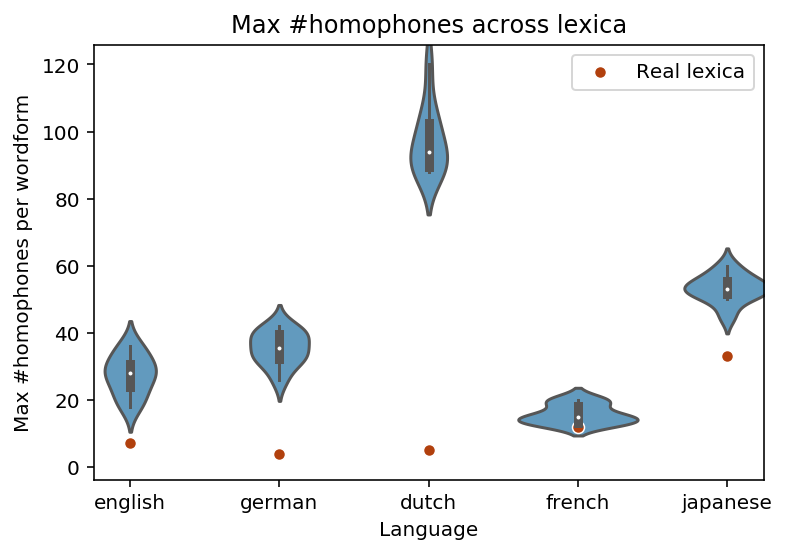

In [17]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
               label = "Simulated"
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
                   y = 'max_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Max #homophones across lexica")
plt.ylabel("Max #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/max_homophones.png", dpi=400, bbox_inches = "tight")

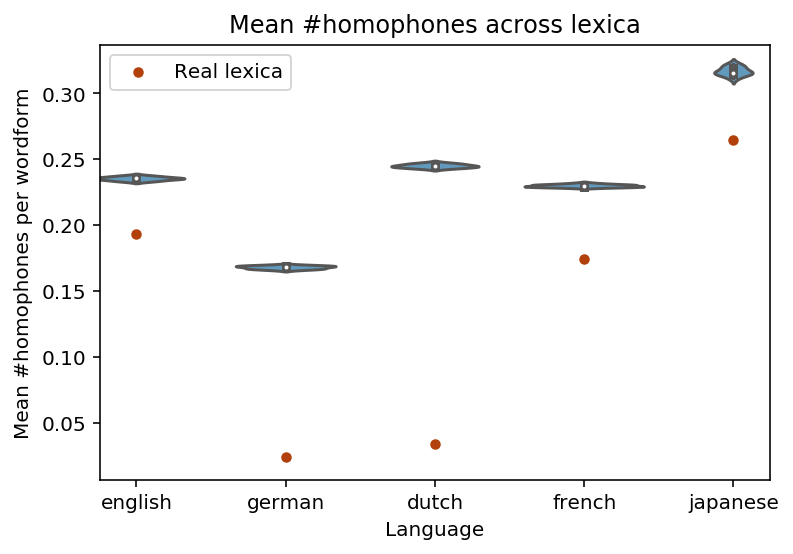

In [18]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_homophones',
           # palette = 'Blues',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
                   x = "language",
           y = 'mean_homophones',
                   color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
    
plt.title("Mean #homophones across lexica")
plt.ylabel("Mean #homophones per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_homophones.png", dpi=400, bbox_inches = "tight")

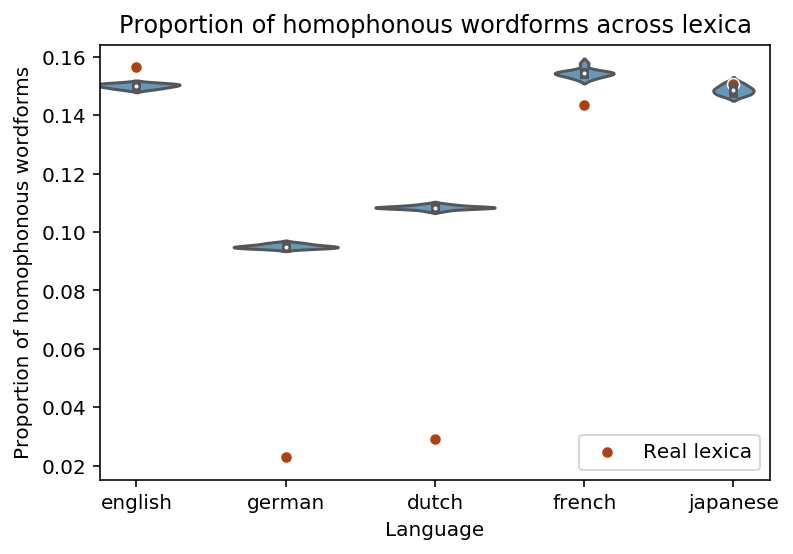

In [19]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'homophone_percentage',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Proportion of homophonous wordforms across lexica")
plt.ylabel("Proportion of homophonous wordforms")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/homophony_rate.png", dpi=400, bbox_inches = "tight")

### Minimal pairs

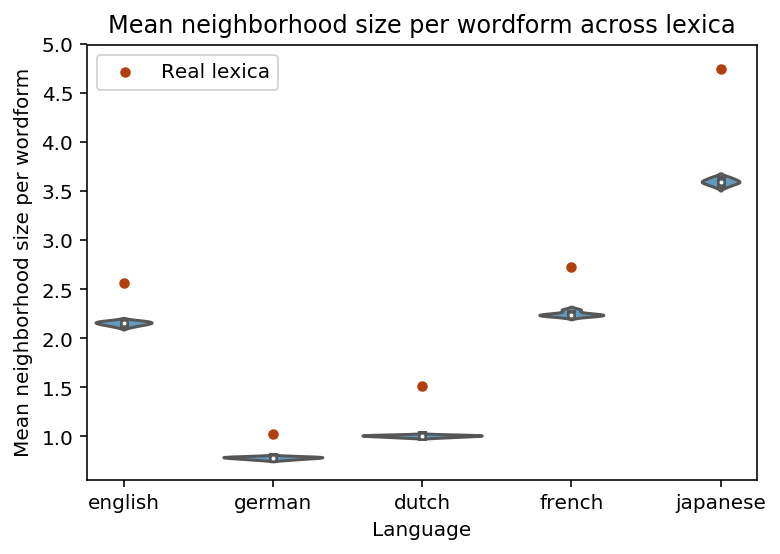

In [21]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'mean_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Mean neighborhood size per wordform across lexica")
plt.ylabel("Mean neighborhood size per wordform")
plt.xlabel("Language")
plt.savefig("Figures/combined/descriptive/mean_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

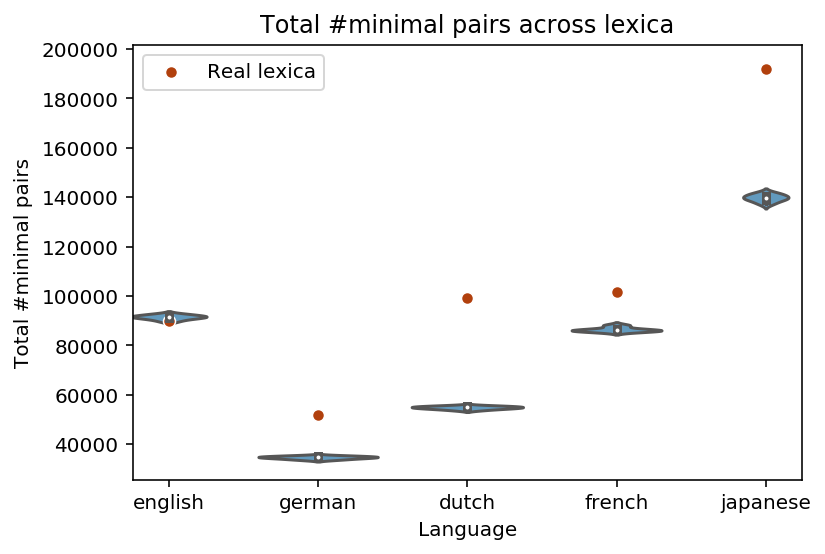

In [22]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'total_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Total #minimal pairs across lexica")
plt.ylabel("Total #minimal pairs")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/total_mps.png", dpi=400, bbox_inches = "tight")

Text(0.5, 0, 'Language')

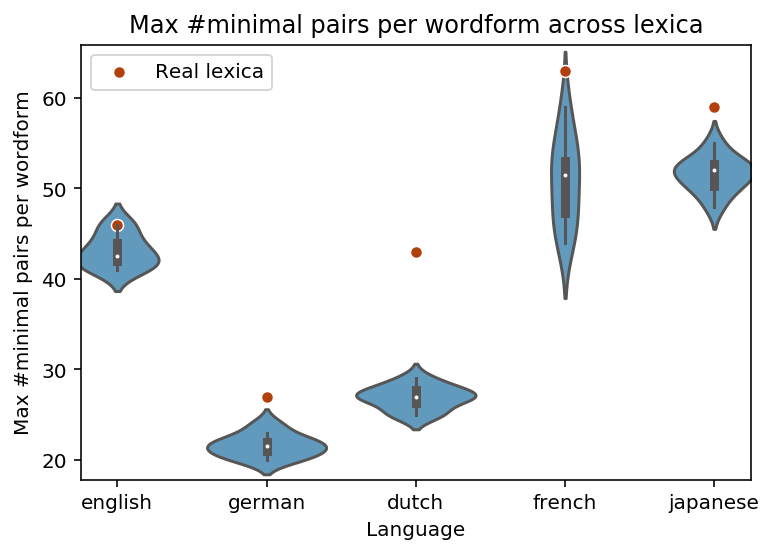

In [23]:
sns.violinplot(data = df_descriptive[df_descriptive['real']=="No"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_descriptive[df_descriptive['real']=="Yes"],
           x = "language",
           y = 'max_mp',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("Max #minimal pairs per wordform across lexica")
plt.ylabel("Max #minimal pairs per wordform")
plt.xlabel("Language")
# plt.savefig("Figures/combined/descriptive/max_mps.png", dpi=400, bbox_inches = "tight")

## Modeling results

### Model 1: `#homophones ~ #syllables + surprisal`

In [24]:
df_all_model1 = pd.concat(model1_results)

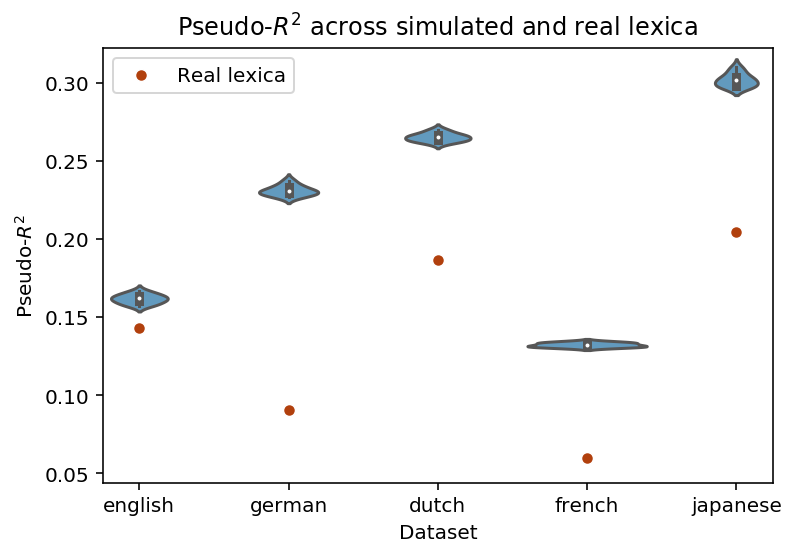

In [25]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_r2.png", dpi=400, bbox_inches = "tight")

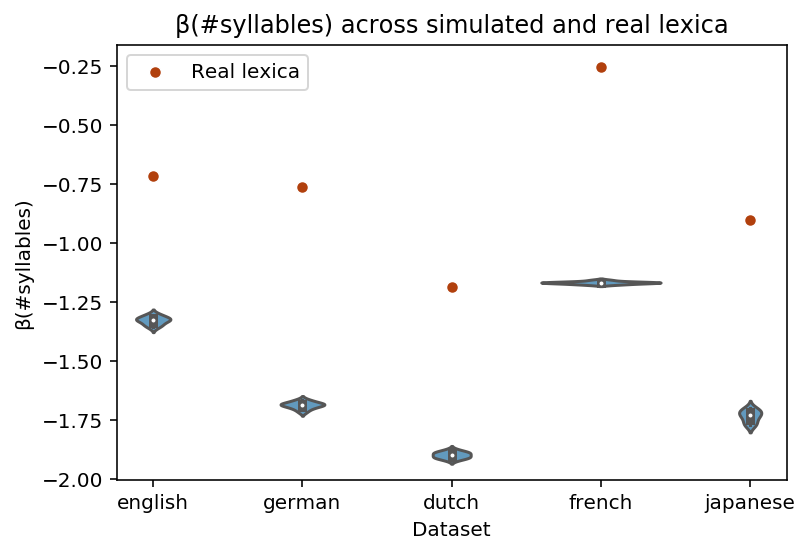

In [26]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_#sylls.png", dpi=400, bbox_inches = "tight")

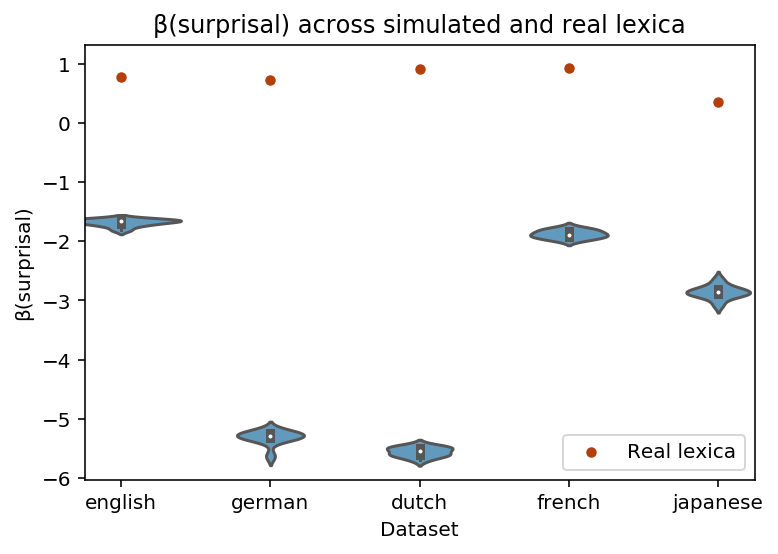

In [27]:
sns.violinplot(data = df_all_model1[df_all_model1['real']=="No"],
           x = "language",
           y = 'surprisal_normed',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model1[df_all_model1['real']=="Yes"],
           x = "language",
           y = 'surprisal_normed',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/modeling/model1_surprisal.png", dpi=400, bbox_inches = "tight")

## Supplementary models

### Model 2: `#homophones ~ #syllables + surprisal`

In [28]:
df_all_model2 = pd.concat(model2_results)

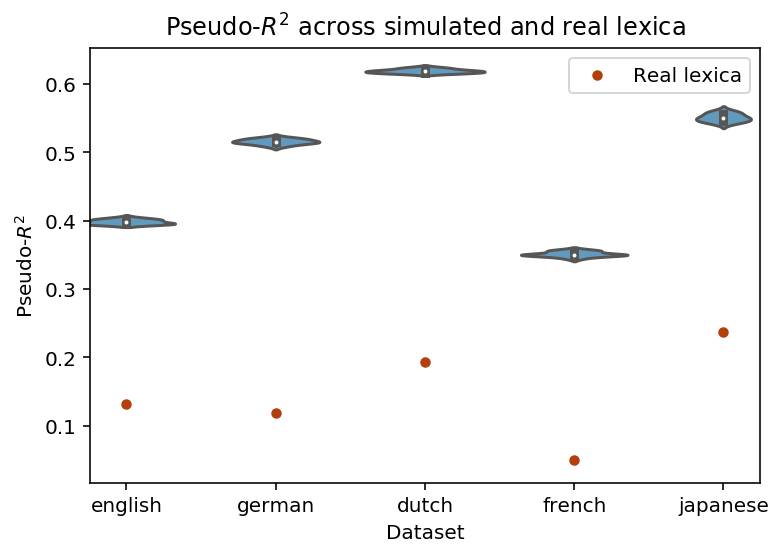

In [30]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'pr2',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'pr2',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )

plt.title("Pseudo-$R^2$ across simulated and real lexica")
plt.ylabel("Pseudo-$R^2$")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model2_r2.png", dpi=400, bbox_inches = "tight")

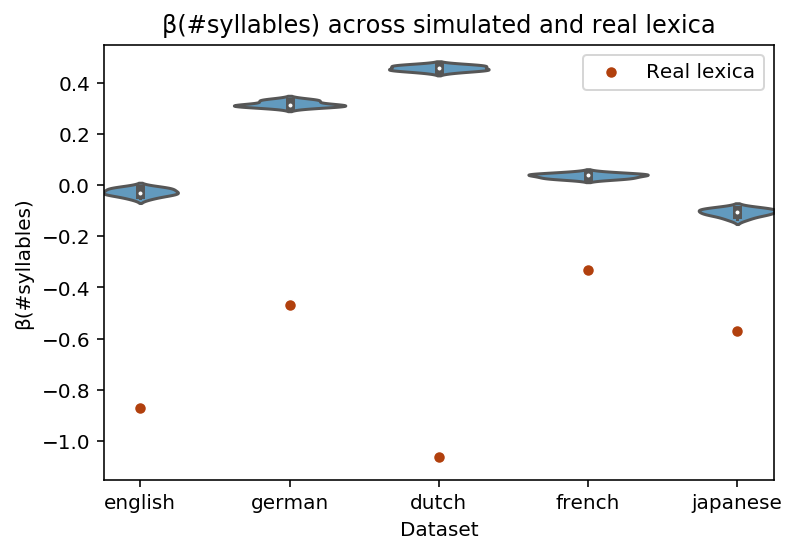

In [31]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'num_sylls_est',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'num_sylls_est',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#syllables) across simulated and real lexica")
plt.ylabel("\u03B2(#syllables)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model2_#sylls.png", dpi=400, bbox_inches = "tight")

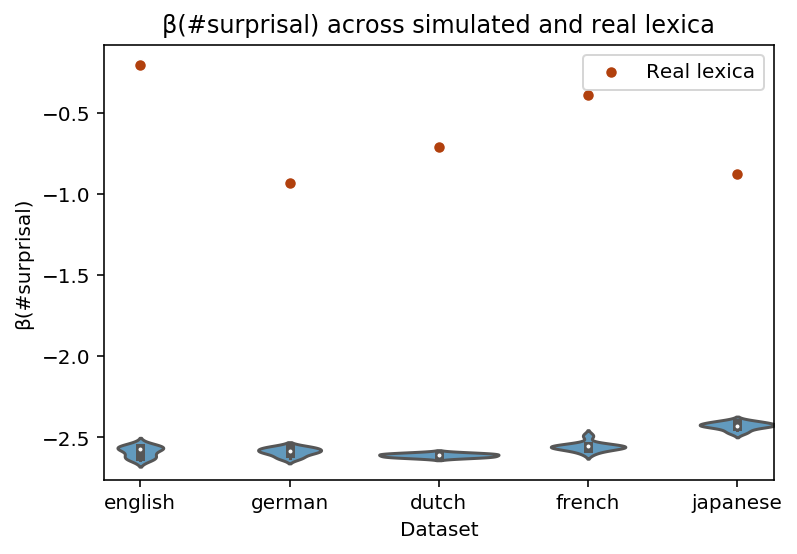

In [32]:
sns.violinplot(data = df_all_model2[df_all_model2['real']=="No"],
           x = "language",
           y = 'surprisal',
            color = sns.color_palette("Blues")[3],
            # hue = "real"
           )

sns.scatterplot(data = df_all_model2[df_all_model2['real']=="Yes"],
           x = "language",
           y = 'surprisal',
           color = sns.color_palette("dark")[1],
                label = "Real lexica"
           # palette = "pastel",
           # hue = "language",
           # legend = False
           )
plt.title("\u03B2(#surprisal) across simulated and real lexica")
plt.ylabel("\u03B2(#surprisal)")
plt.xlabel("Dataset")
plt.savefig("Figures/combined/supplementary/model2_surprisal.png", dpi=400, bbox_inches = "tight")

# Supplementary analyses: biphone model

In [41]:
def process_and_extract_artificials(df_artificials, N=10):
    """Extract each artificial lexicon from aggregated dataframe.
    
    Also returns information about homophony distribution and minimal pair distribution.
    """
    processed_artificials = []
    homophone_percentages = []
    mean_homophones, max_homophones = [], []
    mean_mp, max_mp, total_mp = [], [], []
    # Neighborhood size with homophones
    mean_mp_hp, max_mp_hp, total_mp_hp = [], [], []
    for i in tqdm(range(N)):

        df_tmp = df_artificials[df_artificials['lexicon']==i]

        df_tmp_processed = utils.preprocess_for_analysis(df_tmp, phon_column="word", word_column="word", verbose=False)
        
        lex_stats = utils.get_homophone_stats(df_tmp_processed)

        homophone_percentages.append(lex_stats['homophone_percentage'])
        mean_homophones.append(lex_stats['mean_homophones'])
        max_homophones.append(lex_stats['max_homophones'])
                
        processed_artificials.append(df_tmp_processed)
    
    return {'processed_dataframes': processed_artificials,
            'homophone_percentage': homophone_percentages,
            'mean_homophones': mean_homophones,
            'max_homophones': max_homophones
           }
    

## English

In [59]:
df_real = pd.read_csv("data/processed/english/english_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/english/english_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/english/english_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [60]:
english_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [61]:
info_for_english = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


In [62]:
processed_artificials = info_for_english['processed_dataframes']

#### Norm surprisal

In [63]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [64]:
max_m = round(np.mean(info_for_english['max_homophones']), 2)
max_std = round(np.std(info_for_english['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = english_stats['max_homophones']))

Max homophony: 
Artificial: M = 434.3, SD = 26.272
Real: 7


In [65]:
mean_m = round(np.mean(info_for_english['mean_homophones']), 2)
mean_std = round(np.std(info_for_english['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = english_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.13, SD = 0.001
Real: 0.1931


In [66]:
prop_m = round(np.mean(info_for_english['homophone_percentage']), 2)
prop_std = round(np.std(info_for_english['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = english_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.04, SD = 0.0004
Real: 0.1564


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [67]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [68]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [69]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal_normed,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,4.230504,-1.050552,-2.542480,0.304853
std,0.148390,0.108901,0.031269,0.003768
min,4.018361,-1.160712,-2.576906,0.298530
25%,4.107485,-1.133286,-2.566606,0.302814
50%,4.239478,-1.103975,-2.550849,0.305901
75%,4.365461,-0.939193,-2.525528,0.307710
max,4.404717,-0.898959,-2.490742,0.309721


In [70]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal_normed,num_sylls_est,real,pr2,language
0,0.264016,0.104042,-0.944182,Yes,0.130236,english


### `num_homophones ~ #sylls + surprisal`

In [71]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [72]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['english' for i in range(len(df_analysis))]

In [73]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,9.612628,-2.536192,1.284275,0.807300
std,0.047587,0.012269,0.026304,0.003401
min,9.549179,-2.555012,1.249678,0.802227
25%,9.589964,-2.546320,1.269048,0.805174
50%,9.602853,-2.533906,1.281203,0.807062
75%,9.643576,-2.527586,1.298824,0.810228
max,9.692909,-2.518366,1.326593,0.811864


In [74]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal,num_sylls_est,real,pr2,language
0,1.23236,-0.207295,-0.555806,Yes,0.144239,english


## Japanese

In [42]:
df_real = pd.read_csv("data/processed/japanese/japanese_all_reals_2phone.csv")
df_lemmas = pd.read_csv("data/processed/japanese/japanese_lemmas_processed_2phone.csv")
df_artificials = pd.read_csv("data/processed/japanese/japanese_artificial_10_matched_on_sylls_no_restriction_2phone.csv")


In [43]:
japanese_stats = utils.get_homophone_stats(df_lemmas)

### Preprocess artificials

In [44]:
info_for_japanese = process_and_extract_artificials(df_artificials)

100%|██████████| 10/10 [00:09<00:00,  1.03s/it]


In [45]:
processed_artificials = info_for_japanese['processed_dataframes']

#### Norm surprisal

In [46]:
df_lemmas['surprisal_normed'] = df_lemmas['surprisal'] / df_lemmas['num_phones']
for p in processed_artificials:
    p['surprisal_normed'] = p['surprisal'] / p['num_phones']

## Descriptive

In [47]:
max_m = round(np.mean(info_for_japanese['max_homophones']), 2)
max_std = round(np.std(info_for_japanese['max_homophones']), 3)
print("Max homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = max_m, max_std=max_std))
print("Real: {m}".format(m = japanese_stats['max_homophones']))

Max homophony: 
Artificial: M = 89.6, SD = 7.902
Real: 33


In [48]:
mean_m = round(np.mean(info_for_japanese['mean_homophones']), 2)
mean_std = round(np.std(info_for_japanese['mean_homophones']), 3)
print("Mean homophony: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = mean_m, max_std=mean_std))
print("Real: {m}".format(m = japanese_stats['mean_homophones']))

Mean homophony: 
Artificial: M = 0.17, SD = 0.002
Real: 0.2645


In [49]:
prop_m = round(np.mean(info_for_japanese['homophone_percentage']), 2)
prop_std = round(np.std(info_for_japanese['homophone_percentage']), 4)
print("Proportion of homophonous wordforms: ")
print("Artificial: M = {max_m}, SD = {max_std}".format(max_m = prop_m, max_std=prop_std))
print("Real: {m}".format(m = japanese_stats['homophone_percentage']))

Proportion of homophonous wordforms: 
Artificial: M = 0.06, SD = 0.0007
Real: 0.1506


## Modeling

### `num_homophones ~ #sylls + surprisal_normalized`

In [50]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal_normed',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [52]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['japanese' for i in range(len(df_analysis))]

In [53]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal_normed,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,9.577225,-3.578190,-2.432676,0.439138
std,0.169254,0.123031,0.014904,0.002325
min,9.250398,-3.785754,-2.455498,0.435766
25%,9.491668,-3.632913,-2.444548,0.437387
50%,9.568905,-3.582438,-2.434151,0.439072
75%,9.691757,-3.509414,-2.423466,0.440687
max,9.818905,-3.353989,-2.411178,0.442924


In [54]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal_normed,num_sylls_est,real,pr2,language
0,4.650302,-1.699234,-1.190803,Yes,0.220175,japanese


### `num_homophones ~ #sylls + surprisal`

In [55]:
# Set up models
TARGET_MODEL_1 = 'num_homophones'
COVARIATES_MODEL_1 = [
    'surprisal',
    'num_sylls_est',
]
FORMULA_MODEL_1 = '{y} ~ {regressors}'.format(y=TARGET_MODEL_1, regressors=' + '.join(COVARIATES_MODEL_1))

In [56]:
# Run model 1
df_analysis = analyze_stats(df_lemmas, processed_artificials, formula=FORMULA_MODEL_1, 
                            covariates=COVARIATES_MODEL_1)
df_analysis['language'] = ['japanese' for i in range(len(df_analysis))]

In [57]:
df_analysis[df_analysis['real']=="No"].describe()

,Intercept,surprisal,num_sylls_est,pr2
count,10.000000,10.000000,10.000000,10.000000
mean,8.127253,-2.547732,1.415252,0.722050
std,0.033093,0.023547,0.030669,0.002845
min,8.074728,-2.588462,1.357205,0.716083
25%,8.104962,-2.561920,1.402828,0.721328
50%,8.123848,-2.549514,1.415550,0.722085
75%,8.141179,-2.532721,1.436552,0.723340
max,8.191882,-2.506216,1.461680,0.727175


In [58]:
df_analysis[df_analysis['real']=="Yes"]

,Intercept,surprisal,num_sylls_est,real,pr2,language
0,3.723139,-0.795718,0.064136,Yes,0.278735,japanese
